## Preamble

+ Run these lines of code first to import the necessary libraries and set up the plotting environment.

In [1]:
## Preamble / required packages
import numpy as np
np.random.seed(0)

## Import local plotting functions and in-notebook display functions
import matplotlib.pyplot as plt
from IPython.display import Image, display
%matplotlib inline

import warnings
## Comment this out to activate warnings
warnings.filterwarnings('ignore')


# plt.style.use("dark_background")

## Background: May and stability-complexity



### Create a high-dimensional dynamical system


$$
\dot{x}_i = \sum_{ij} A_{ij} x_i x_j - x_i^3
$$

In [105]:
from scipy.integrate import solve_ivp

class RandomConfined:
    """
    n: int, The number of interacting components
    """
    def __init__(self, n):
        self.n = n
        self.k2 = np.random.normal(size=(n, n))
        self.k3 = np.random.normal(size=(n, n, n))
        
        self.k2 = 0.5*(self.k2.T + self.k2)
            
    def __call__(self, x, t):
        return np.matmul(self.k2, x) + np.tensordot(self.k3, x[:, None]*x[None, :], axes=2) - .001*x**3
#         return np.matmul(self.k2, x)  #- x**3

np.random.seed(25)
eq = RandomConfined(30)
ic = np.random.normal(size=30)
tpts = np.linspace(0, 10, 100000)

yfun = lambda t, y : eq(y, t)
fsol = solve_ivp(yfun, (0, 5000), ic, method="BDF")
# fsol = solve_ivp(yfun, (0, 0.1), ic, method="DOP853", t_eval=np.linspace(0, 0.1, 100000))
sol = fsol.y

# sol = odeint(eq, ic, tpts).T

plt.plot(sol[0])

KeyboardInterrupt: 

(300, 349) (349,)


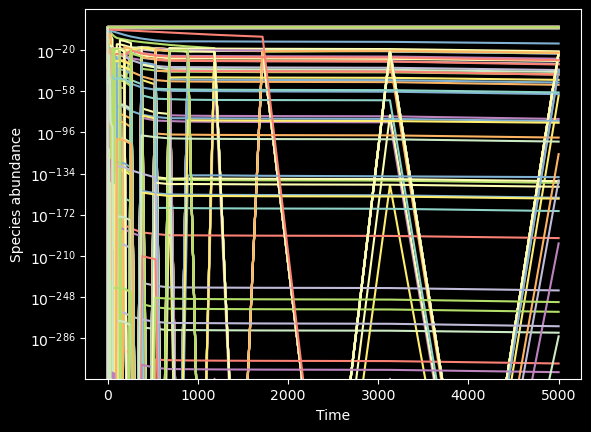

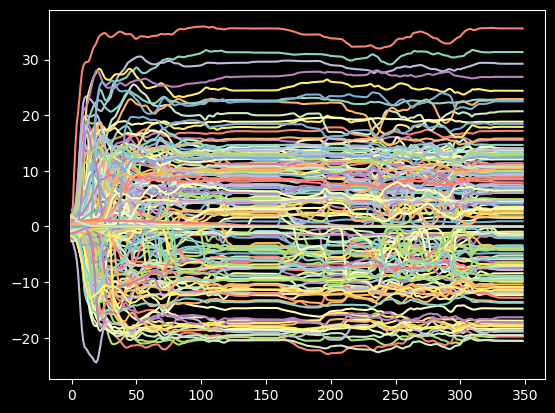

In [310]:
from scipy.integrate import solve_ivp

class RandomLotkaVolterra:

    def __init__(self, n_species, random_state=None):
        self.n_species = n_species
        self.random_state = random_state
        np.random.seed(random_state)
        self.A = np.random.normal(size=(n_species, n_species))
        self.A = self.A + self.A.T
        # self.A[0] = -np.abs(self.A[0])
        self.r = np.random.normal(size=n_species)

    def __call__(self, t, x):
        return self.rhs(t, x)
    
    def rhs(self, t, x):
        return self.r * x * (1 - self.A @ x) - x**3
    

model = RandomLotkaVolterra(300, random_state=0)
x0 = np.random.normal(size=model.n_species)
traj = solve_ivp(model, (0, 5000), x0, method="Radau")
print(traj.y.shape, traj.t.shape)
X_traj = traj.y.T.copy()

plt.figure()
plt.semilogy(traj.t, traj.y.T);
plt.xlabel("Time")
plt.ylabel("Species abundance")

plt.figure()
plt.plot(traj.y.T);

In [313]:




class RandomCubicDynamics:

    def __init__(self, n_species, random_state=None):
        self.n_species = n_species
        self.random_state = random_state
        np.random.seed(random_state)
        self.A = np.random.normal(size=(n_species, n_species, n_species))
        self.B = np.random.normal(size=(n_species, n_species))
        self.B = 0.5 * (self.B + self.B.T)
        # self.A = self.A + self.A.transpose((0, 2, 1)) # ? Remove
        # self.A = self.A + self.A.transpose((1, 0, 2))

        # set diagonal to zero
        # self.A[:, np.arange(n_species), np.arange(n_species)] = 0
        # self.B[np.arange(n_species), np.arange(n_species)] = 0

        # force there to be a stable fixed point
        self.B[:, 0] = -np.abs(self.B[:, 0]) * n_species
        self.A[:, 0, :] = -np.abs(self.A[:, 0, :]) * n_species

    def __call__(self, t, x):
        return self.rhs(t, x)
    
    def rhs(self, t, x):
        # ee = np.tensordot(self.A, x[:, None] * x[None, :], axes=2)
        # print(ee.shape)

        return self.B @ x + np.einsum('ijk,ik->j', self.A, x[:, None] * x[None, :]) - .001*x**3 * 100

    

# model = RandomLotkaVolterra(100, random_state=0)
# x0 = np.random.normal(size=model.n_species)
# traj = solve_ivp(model, (0, 500), x0, t_eval=np.linspace(0, 500, 1000))

model = RandomCubicDynamics(100, random_state=25)
# model = RandomCubicDynamics(30, random_state=25)
# model = RandomCubicDynamics(50, random_state=50)
# model = RandomCubicDynamics(100, random_state=10)
x0 = np.random.normal(size=model.n_species)
traj = solve_ivp(model, (0, 5000), x0, method="Radau")
X_traj = traj.y.T.copy()

plt.semilogy(traj.t, traj.y.T);
plt.xlabel("Time")
plt.ylabel("Species abundance")

plt.figure()
plt.plot(traj.y.T);

KeyboardInterrupt: 

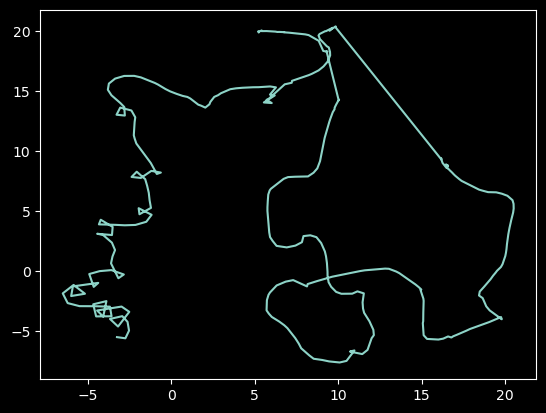

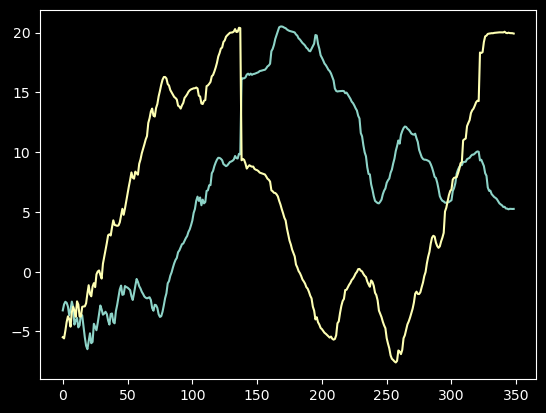

In [312]:
# from umap import UMAP

umap = UMAP(n_components=2, densmap=True, n_neighbors=5)
traj_umap = umap.fit_transform(X_traj)

plt.figure()
plt.plot(traj_umap[:, 0], traj_umap[:, 1], linewidth=0.1);

# plt.figure()
# plt.plot(traj.t, traj_umap);

plt.figure()
plt.plot(traj_umap);

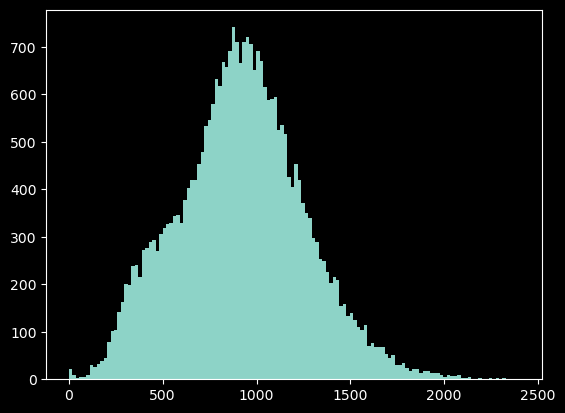

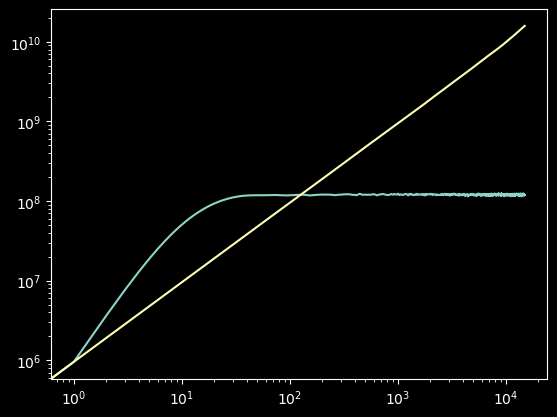

In [274]:
jump_lengths = np.linalg.norm(np.diff(X_traj, axis=0), axis=1)
plt.figure()
plt.hist(jump_lengths, bins=130);


def compute_msd(trajectory):
    T, D = trajectory.shape
    msd = np.zeros(T // 2)
    for i in range(1, T // 2):
        sqdist = (trajectory[i:] - trajectory[:-i])**2
        msd[i] = np.mean(np.sum(sqdist, axis=1))
        
    return msd



# msd = compute_msd(X_traj)
plt.figure()
plt.loglog(msd)

X_traj_brownian = np.cumsum(100**2*np.random.normal(size=X_traj.shape), axis=0)
# msd_brownian = compute_msd(X_traj_brownian)
# plt.figure()
plt.loglog(msd_brownian / msd_brownian[1] * msd[1])

# plt.xlim([0, 100])

# Saddle points dominate the dynamics

# Kantz-Grassberger



## What do individual trajectories look like?

+ If saddle escapes occur along random directions, then the integral of each dimension should look like Brownian motion.

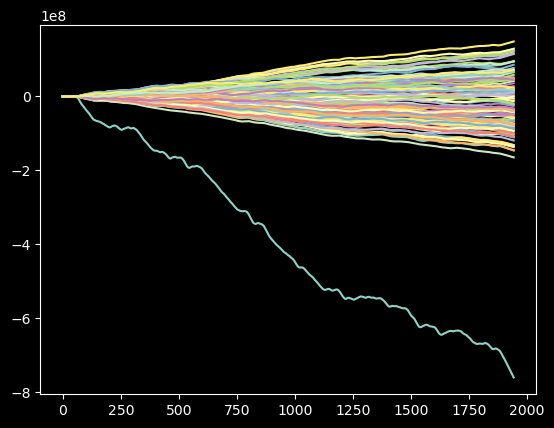

In [195]:
traj_integ = np.cumsum(traj.y.T, axis=0)

plt.figure()
plt.plot(traj_integ);

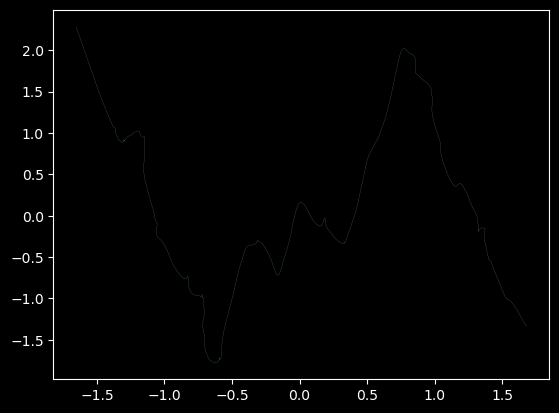

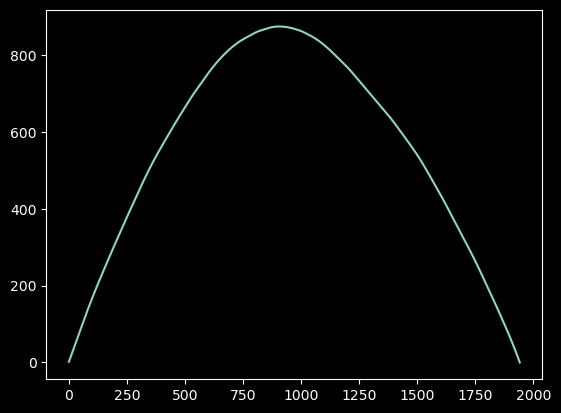

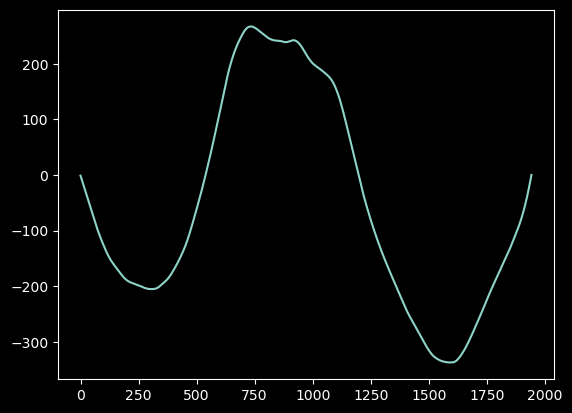

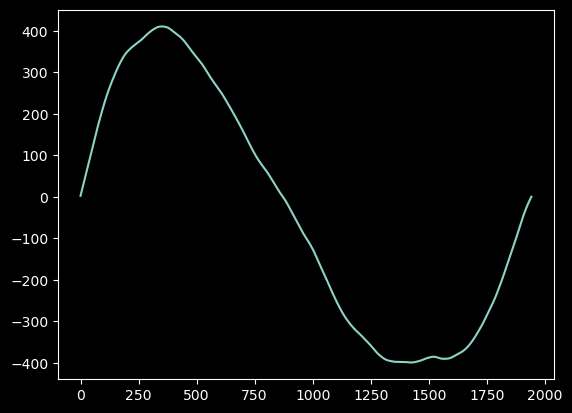

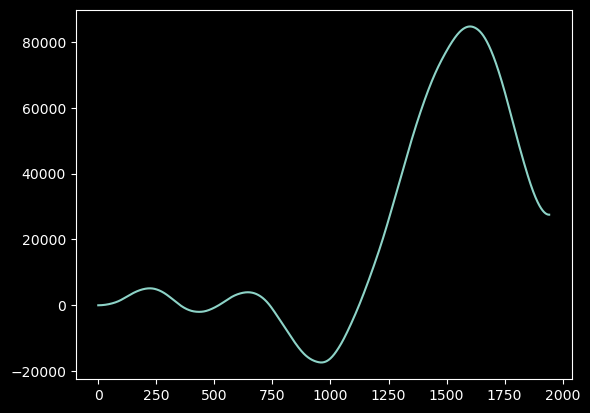

In [194]:
from sklearn.decomposition import PCA

pca = PCA(n_components=4, whiten=True)
traj_pca = pca.fit_transform(np.cumsum(traj.y.T, axis=0))

plt.figure()
plt.plot(traj_pca[:, 0], traj_pca[:, 1], linewidth=0.1);


plt.figure()
plt.plot(np.cumsum(traj_pca[:, 0]));
plt.figure()
plt.plot(np.cumsum(traj_pca[:, 1]));
plt.figure()
plt.plot(np.cumsum(traj_pca[:, 2]));
plt.figure()
plt.plot(np.cumsum(np.cumsum(traj_pca[:, 3])));

# plt.figure()
# plt.plot(traj.t, traj_pca);

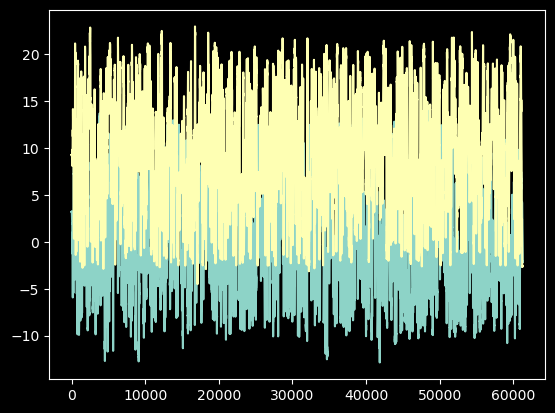

In [153]:
plt.plot(traj_umap);

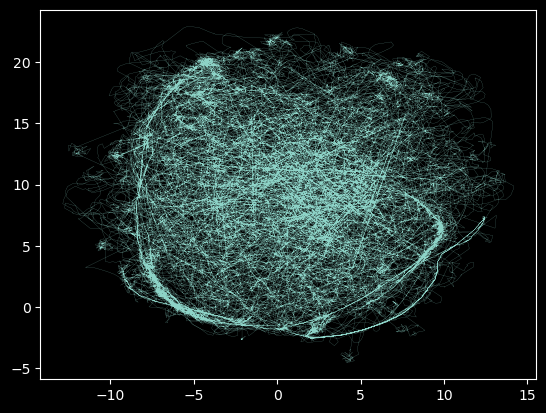

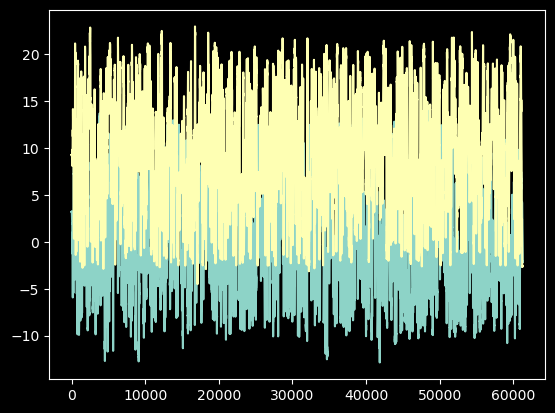

In [150]:
# from umap import UMAP

umap = UMAP(n_components=2, densmap=True, n_neighbors=5)
traj_umap = umap.fit_transform(traj.y.T)

plt.figure()
plt.plot(traj_umap[:, 0], traj_umap[:, 1], linewidth=0.1);

# plt.figure()
# plt.plot(traj.t, traj_umap);

plt.figure()
plt.plot(traj_umap);

# Dimensionality and autocorrelation

In [ ]:
def pairwise_autocorrelation(ts):
    """
    Compute the pairwise correlation between all pairs of points
    """
    max_spacing = ts.shape[0] // 2
    corrs = np.zeros((max_spacing, ts.shape[1]))
    

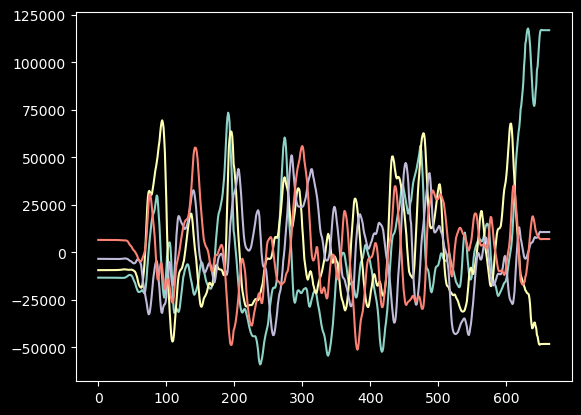

In [ ]:
plt.plot(traj_pca);

### Grassberger-Kantz relationship

$$
\kappa = \sum_j \lambda_j (1 - D_I^{(j)})
$$
where $\kappa$ is the escape rate from the saddle, $\lambda_j$ is the $j$th positive Lyapunov exponent and $D_I^{(j)}$ is the partial information dimension of the $j$th Lyapunov vector.

+ Dauphin et al
+ PDEs
+ Transient chaos


### Transposing the data matrix

+ What happens if we perform PCA on the trajectories, not the time series?

In [1]:
from dysts.flows import Lorenz96

eq = Lorenz96()

In [11]:
eq.ic[-1:].shape

(1,)

## How do inner products scale with system dimensionality?

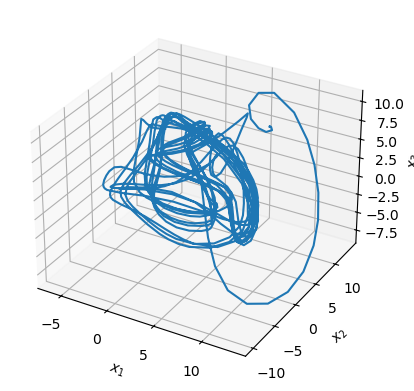

In [28]:
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import numpy as np

# These are our constants
N = 5  # Number of variables
F = 8  # Forcing


def L96(x, t):
    """Lorenz 96 model with constant forcing"""
    # Setting up vector
    d = np.zeros(N)
    # Loops over indices (with operations and Python underflow indexing handling edge cases)
    for i in range(N):
        d[i] = (x[(i + 1) % N] - x[i - 2]) * x[i - 1] - x[i] + F
    # periodic boundary conditions
    # d[-1] = (x[0] - x[-3]) * x[-2] - x[-1] + F
    # d[-2] = (x[1] - x[-4]) * x[-3] - x[-2] + F
    # d[-3] = (x[2] - x[-5]) * x[-4] - x[-3] + F
    return d


x0 = F * np.ones(N)  # Initial state (equilibrium)
x0[0] += 0.01  # Add small perturbation to the first variable
t = np.arange(0.0, 30.0, 0.01)

rhs = lambda t, x: L96(x, t)
# x = odeint(rhs, ic, t)
sol = solve_ivp(rhs, (0, 30), ic, method="Radau")
x = sol.y.T

# Plot the first three variables
fig = plt.figure()
ax = fig.add_subplot(projection="3d")
ax.plot(x[:, 0], x[:, 1], x[:, 2])
ax.set_xlabel("$x_1$")
ax.set_ylabel("$x_2$")
ax.set_zlabel("$x_3$")
plt.show()


In [74]:
ic.shape

(10,)

(-8.64900549214583, 13.080709536934034, -9.547737346574515, 15.287917008868487)

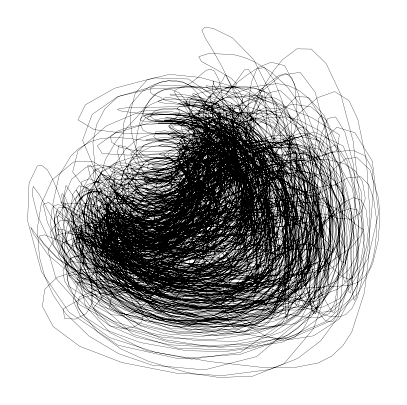

In [85]:
from scipy.integrate import solve_ivp

def twopoint_correlation(X, center=True):
    """
    Compute the instantaneous pairwise correlation between all pairs of timepoints

    Args:
        X (np.ndarray): shape (T, D)
    """
    if center:
        X = X - np.mean(X, axis=0, keepdims=True)
    max_time = X.shape[0] // 2
    corrs = np.zeros(max_time)
    for i in range(1, max_time):
        corrs[i] = np.mean(np.sum(X[i:] * X[:-i], axis=1))
    return corrs


class Lorenz96:
    """
    Lorenz 96 model with constant forcing
    """

    def __init__(self, n=4, f=8.0):
        self.f = f
        self.n = n

    def rhs(self, t, X):

        Xdot = np.zeros_like(X)
        Xdot[2:-1] = (X[3:] - X[:-3]) * X[1:-2] - X[2:-1] + self.f
        Xdot[0] = (X[1] - X[-2]) * X[-1] - X[0] + self.f
        Xdot[1] = (X[2] - X[-1]) * X[0] - X[1] + self.f
        Xdot[-1] = (X[0] - X[-3]) * X[-2] - X[-1] + self.f

        return Xdot
    
    def __call__(self, *args, **kwargs):
        return self.rhs(*args, **kwargs)

eq = Lorenz96



nval = 15

eq = Lorenz96(n=nval)
ic = eq.f * np.ones(eq.n) #+ 0.01 * np.random.normal(size=eq.n)
ic[0] += 0.01
# sol = solve_ivp(eq.rhs, [0, 30], ic, vectorized=True, max_step=0.01)
sol = solve_ivp(eq, (0, 500), ic, method="Radau")
ysol = sol.y.T
ysol = ysol[500:] # discard transient

plt.figure(figsize=(5, 5))
plt.plot(ysol[:, 0], ysol[:, 1], 'k', linewidth=0.2);
plt.axis("off")



We loop over many values of $N$, simulate the system, and then record the two-point correlation function for each value of $N$.

In [117]:


nvals = np.arange(5, 100, 5)
# nvals = np.unique(5 * np.logspace(0, 3, 30)).astype(int)
all_corrs = []
for nval in nvals:
    print(f"Starting nval = {nval}")
    eq = Lorenz96(n=nval)
    ic = eq.f * np.ones(eq.n) #+ 0.01 * np.random.normal(size=eq.n)
    ic[0] += 0.01
    sol = solve_ivp(eq, (0, 500), ic, method="Radau")
    ysol = sol.y.T
    ysol = ysol[500:] # discard transient

    # test comparison: random normal
    # ysol = np.random.normal(size=(500, nval))

    all_corrs.append(twopoint_correlation(ysol))



Starting nval = 5
Starting nval = 10
Starting nval = 15
Starting nval = 20
Starting nval = 25
Starting nval = 30
Starting nval = 35
Starting nval = 40
Starting nval = 45
Starting nval = 50
Starting nval = 55
Starting nval = 60
Starting nval = 65
Starting nval = 70
Starting nval = 75
Starting nval = 80
Starting nval = 85
Starting nval = 90
Starting nval = 95


Text(0, 0.5, 'Asymptotic Standard deviation of pairwise correlations')

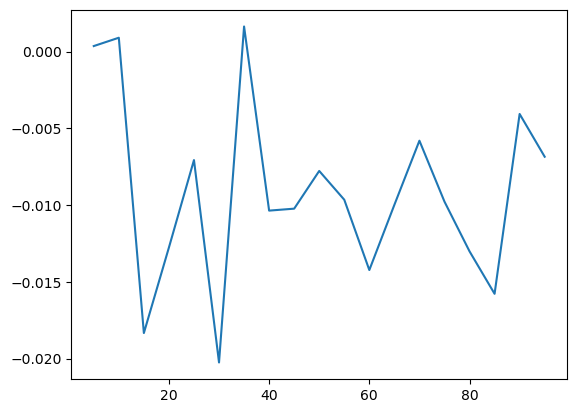

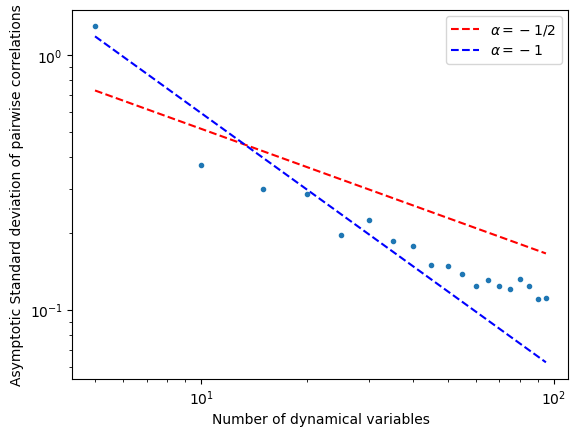

In [123]:
## fit a power law nvals, scaled_std
from scipy.optimize import curve_fit

mean_asymp = [np.mean(corr[-3000:]) for corr in all_corrs]
std_asymp = [np.std(corr[-3000:]) for corr in all_corrs]

plt.figure()
plt.plot(nvals, mean_asymp / nvals)

plt.figure()
scaled_std = std_asymp / nvals
plt.loglog(nvals, scaled_std, '.')
plt.xlabel("Number of dynamical variables")
plt.ylabel("Asymptotic mean of pairwise correlations")
# plt.plot(nvals, (1 / np.sqrt(nvals)) * np.sqrt(nvals)[0] * scaled_std[0], '--k')



# power_law = lambda x, a, b:  a * x**b
# popt, pcov = curve_fit(power_law, nvals, scaled_std)
# print(popt)
# plt.plot(nvals, power_law(nvals, *popt), '--k', label=f"Fit: $\\alpha = {popt[1]:.2f}$")


invsq_law = lambda x, a:  a * x**(-0.5)
popt, pcov = curve_fit(invsq_law, nvals, scaled_std)
plt.plot(nvals, invsq_law(nvals, *popt), '--r', label=f"$\\alpha = -1/2$")
invlin_law = lambda x, a:  a * x**(-1.0)
popt, pcov = curve_fit(invlin_law, nvals, scaled_std)
plt.plot(nvals, invlin_law(nvals, *popt), '--b', label=f"$\\alpha = -1$")
plt.legend()
plt.xlabel("Number of dynamical variables")
plt.ylabel("Asymptotic Standard deviation of pairwise correlations")




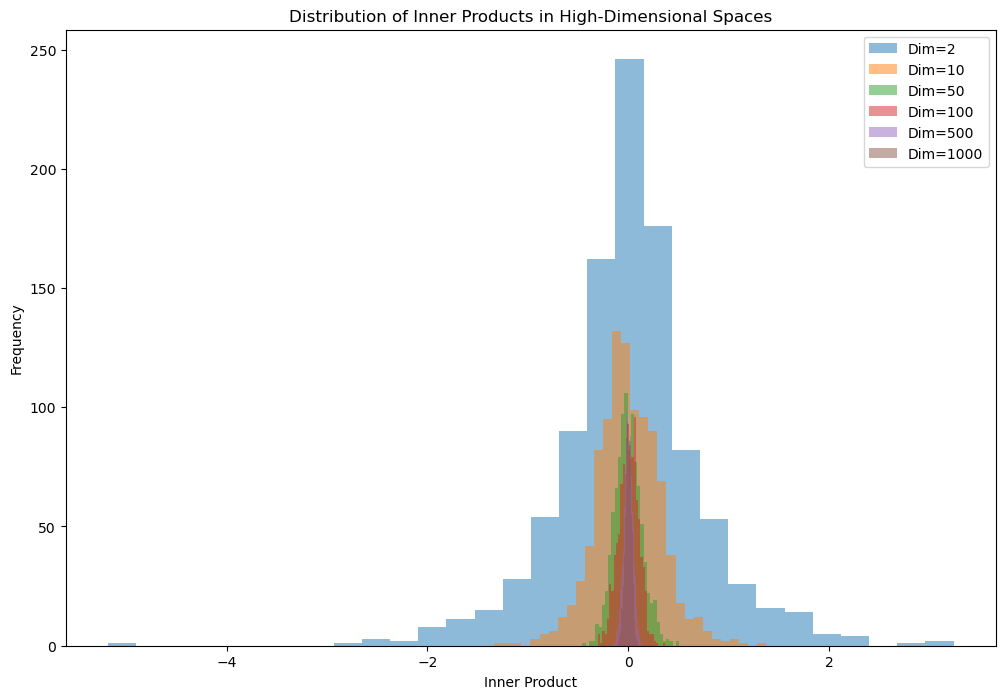

In [97]:
import numpy as np
import matplotlib.pyplot as plt

# Experiment parameters
dimensions = [2, 10, 50, 100, 500, 1000]  # Different dimensions to test
num_pairs = 1000  # Number of random vector pairs for each dimension

# Function to compute inner products for a given dimension
def compute_inner_products(dim, num_pairs):
    inner_products = []
    for _ in range(num_pairs):
        v1 = np.random.normal(0, 1, dim)
        v2 = np.random.normal(0, 1, dim)
        inner_product = np.dot(v1, v2) / dim
        inner_products.append(inner_product)
    return inner_products

# Conduct the experiment
results = {dim: compute_inner_products(dim, num_pairs) for dim in dimensions}

# Plotting the results
plt.figure(figsize=(12, 8))
for dim in dimensions:
    plt.hist(results[dim], bins=30, alpha=0.5, label=f'Dim={dim}')
plt.legend()
plt.title('Distribution of Inner Products in High-Dimensional Spaces')
plt.xlabel('Inner Product')
plt.ylabel('Frequency')
plt.show()


In [89]:
import numpy as np

def grassberger_procaccia(data, max_radius=None, min_radius=0, steps=100):
    """
    Calculate the correlation dimension of a point set using the Grassberger-Procaccia algorithm.

    :param data: (N, D) array of N points in D dimensions
    :param max_radius: Maximum radius to consider (optional)
    :param min_radius: Minimum radius to consider (default 0)
    :param steps: Number of steps between min_radius and max_radius (default 100)
    :return: (radii, correlation_dimension) tuple
    """
    N, D = data.shape

    # Calculate distance matrix
    distance_matrix = np.sqrt(np.sum((data[:, np.newaxis, :] - data[np.newaxis, :, :]) ** 2, axis=-1))

    if max_radius is None:
        max_radius = np.max(distance_matrix) / 2

    # Prepare radii
    radii = np.exp(np.linspace(np.log(min_radius), np.log(max_radius), steps))

    # Calculate correlation sum for each radius
    correlation_sum = np.array([np.sum(distance_matrix < r) for r in radii]) / (N * (N - 1))

    # Calculate the correlation dimension
    log_r = np.log(radii)
    log_c = np.log(correlation_sum)
    correlation_dimension = np.polyfit(log_r, log_c, 1)[0]

    return radii, correlation_dimension

# Example usage
# data = np.random.rand(1000, 2)  # Generate some random 2D points
# radii, dim = grassberger_procaccia(data)
# print("Correlation Dimension:", dim)


(12851, 95)

(-8.568472314039271, 14.471303818328707, -8.44671337420127, 14.10894133567279)

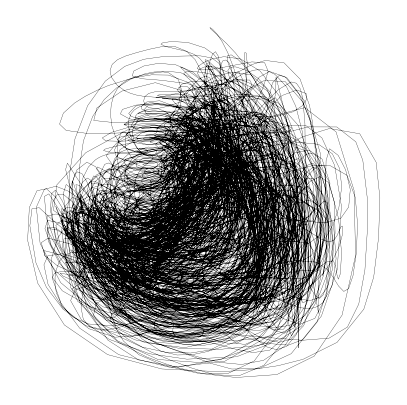

In [92]:
plt.figure(figsize=(5, 5))
plt.plot(ysol[:, -2], ysol[:, -1], 'k', linewidth=0.2);
plt.axis("off")

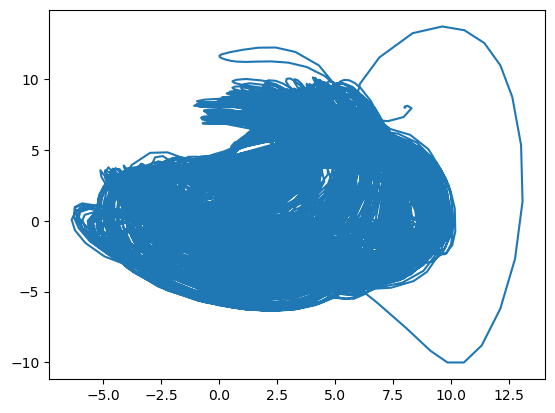

In [55]:
plt.plot(sol.y[0], sol.y[1])

In [ ]:
fpath = "/Users/william/Downloads/test.csv.zip"

import pandas as pd

# df = pd.read_csv(fpath)

## read only part of the file
# df = pd.read_csv(fpath, nrows=500)
## read only some columns
df = pd.read_csv(fpath, nrows=2000)


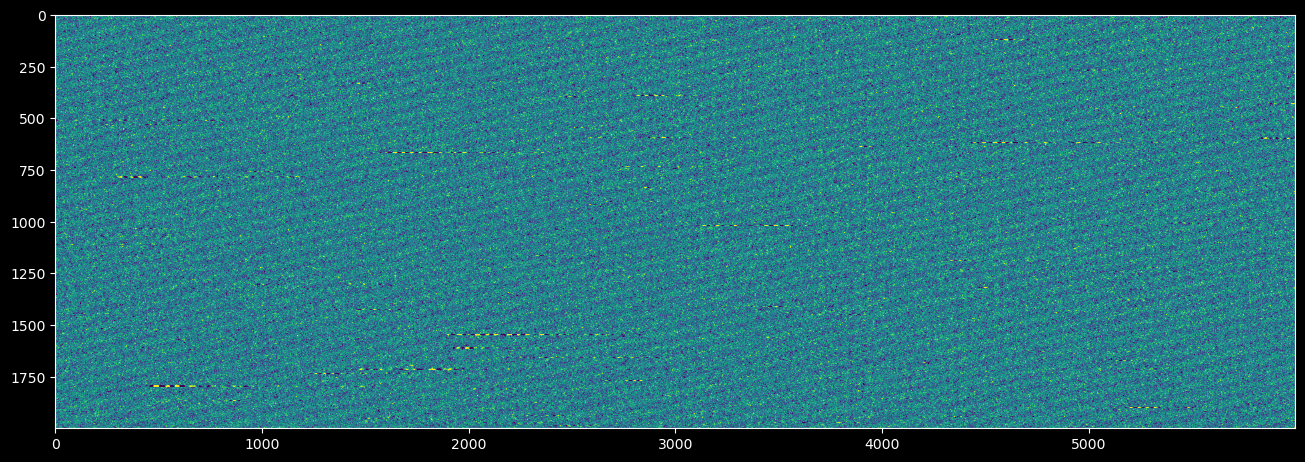

In [ ]:
vals = df.to_numpy()
vals -= np.mean(vals, axis=1, keepdims=True)
vals /= np.std(vals, axis=1, keepdims=True)
plt.figure(figsize=(16, 16))
plt.imshow(vals[:, 1:], vmin=-0.1, vmax=0.1)

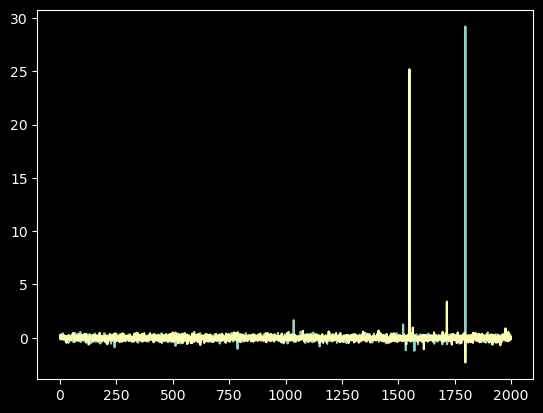

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
plt.plot(pca.fit_transform(vals[:, 1:]))

In [ ]:
traj_umap.shape

(2000, 2)

In [ ]:
from umap import UMAP

umap = UMAP(n_components=2, densmap=True)
traj_umap = umap.fit_transform(vals.T)

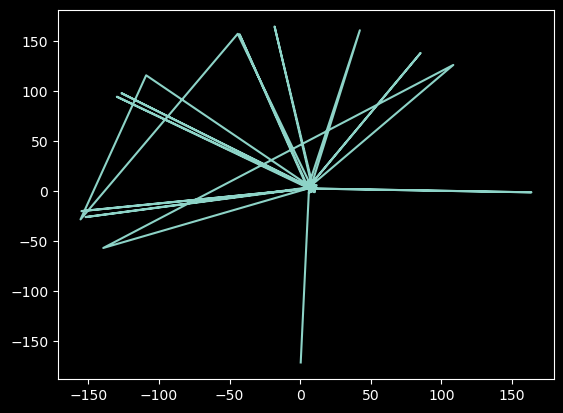

In [ ]:
plt.figure()
plt.plot(traj_umap[:, 0], traj_umap[:, 1]);